In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Number of photons on the detector

In [2]:
cmd = sim.UserCommands("metis_image_NQ.config")
cmd["OBS_EXPTIME"]=1
cmd["ATMO_USE_ATMO_BG"] = "yes"
cmd["SCOPE_USE_MIRROR_BG"] = "yes"
cmd["SIM_VERBOSE"]="no"
cmd["FPA_QE"]="TC_detector_METIS_NQ_no_.dat"
metis_filter_id="N2"
cmd["INST_FILTER_TC"]="TC_filter_" + metis_filter_id + ".dat"

In [3]:
opt = sim.OpticalTrain(cmd)

In [4]:
fpa = sim.Detector(cmd, small_fov=False)

In [5]:
## generate a source with 0 mag
lam, spec = sim.source.flat_spectrum(0, "TC_filter_" + metis_filter_id + ".dat")
src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])
src_chopped = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[1])

#### Compute number of background photons in SimMETIS simulated image

In [6]:
src.apply_optical_train(opt, fpa)
exptime=1
photonflux = fpa.chips[0].array.T
clean_image = photonflux * exptime ## noise free image before applying Poisson noise

hdu = fpa.read_out(OBS_EXPTIME=1) # image including Poisson noise
src_chopped.apply_optical_train(opt,fpa) # the same for the chopped position
hdu_chopped = fpa.read_out(OBS_EXPTIME=1) # the same for the chopped position

Generating image for chip 1
Reading out chip 1 using superfast
3.14446775145e+14 299857898.836 787391188.805 299857898.836
3.14447e+14 2.99778e+08 7.87372e+08 2.99858e+08
Generating image for chip 1
Reading out chip 1 using superfast
3.14446775145e+14 299857898.836 787391188.805 299857898.836
3.14447e+14 2.9977e+08 7.87415e+08 2.99858e+08


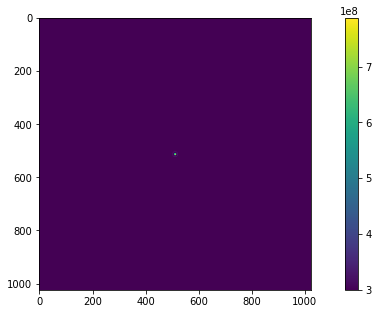

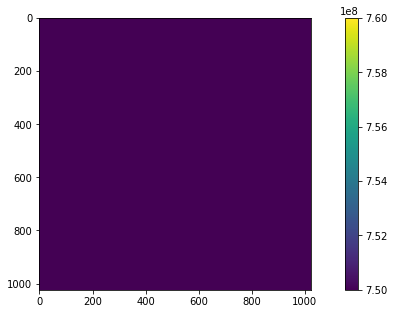

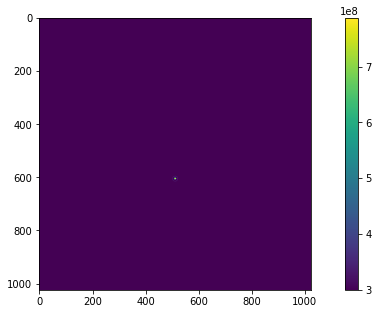

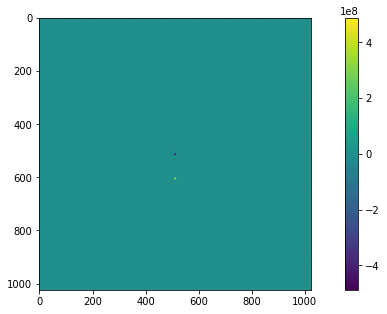

In [7]:
##
## chop A frame
plt.figure(figsize=(12,5))
#plt.imshow(hdu[0].data, interpolation="none", vmin=7.6e8,vmax=7.6e8)
plt.imshow(hdu[0].data, interpolation="none")
plt.colorbar()
##
## chop A frame without noise
plt.figure(figsize=(12,5))
plt.imshow(clean_image, interpolation="none", vmin=7.5e8,vmax=7.6e8)
plt.colorbar()
##
## chop B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data, interpolation="none")
plt.colorbar()
##
## chop difference A-B frame
## this is the "final science-grade data product" in this simulation. Nodding is not required
##    since it is only needed to correct for chop-residuals which we do not simulate.
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data-hdu[0].data, interpolation="none")
plt.colorbar()

## ELFN

In [8]:
from  scipy.interpolate import interp1d
def ELFN_penalty(photonflux):
    x=[0, 2e8, 8e8,10e8,25e8] # [ph/s/pix]
    y=[1,1.37,3.38,3.64,4.65] # ELFN noise penalty factor
    penalty_interp=interp1d(x,y)
    penalty=penalty_interp(photonflux)[()]
    return(penalty)

In [9]:
## in order to simulate ELFN noise with SimMETIS, we currently take the following approach:
##
## (1) we first generate an image of pure noise by removing a noise-less image 
##     from the final image)
noise = hdu[0].data - clean_image
##
## (2) then we multiply the ELFN noise penalty to this noise image and add the noise
##     back to the noiseless image; the result is the final ("chop-nod subtracted") frame 
##     including ELFN.
elfn_image = clean_image + ELFN_penalty(photonflux)*noise
##
## we can compare the noise from before with the noise after and see that the noise has
##    increased by about a factor of 2.5, as expected given the background level ~ 5e8 ph/s/px.
print(np.std(hdu[0].data[200:400,200:400]))
print(np.std(elfn_image[200:400,200:400]))

17327.9493735
29532.2545038
